In [22]:
import jax
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import random, vmap, jit, grad
import jax.scipy as scipy

from jax import random



import matplotlib.pyplot as plt

from utils_rough_pde import *
from utils_elliptic_coef import *

import time

# Computing the spectral decomposition using the FFT

In [2]:
domain = jnp.array([0,1])

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [3]:
f = lambda x: jnp.cos(2*jnp.pi*x) + 2*jnp.sin(2*jnp.pi*4*x)

In [4]:
n_points = 100
grid = jnp.linspace(domain[0], domain[1], n_points)

In [5]:
y_values = f(grid)

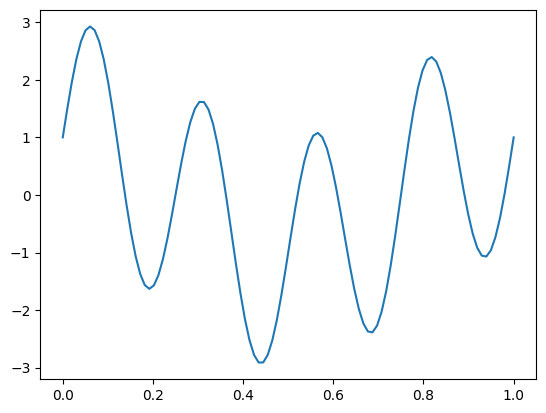

In [6]:
plt.plot(grid, y_values)

In [7]:
from jax.numpy import fft

In [8]:
alpha = fft.fft(y_values)

In [9]:
alpha.shape

(100,)

In [10]:
alpha

Array([ 1.        +0.00000000e+00j, 50.23467546+1.05387703e+00j,
       -0.25956919-1.32402682e+00j,  0.18314295-3.29410720e+00j,
       12.36881556-9.84512701e+01j, -0.76952774+4.58774434e+00j,
       -0.49050447+2.41658375e+00j, -0.3992566 +1.68948687e+00j,
       -0.35450836+1.31627630e+00j, -0.32834612+1.08507545e+00j,
       -0.3114331 +9.25702238e-01j, -0.29975411+8.08015012e-01j,
       -0.29130099+7.16839951e-01j, -0.28496176+6.43664349e-01j,
       -0.2800736 +5.83320445e-01j, -0.27621862+5.32476809e-01j,
       -0.2731214 +4.88881831e-01j, -0.27059379+4.50954517e-01j,
       -0.26850336+4.17549292e-01j, -0.26675452+3.87813927e-01j,
       -0.26527677+3.61100059e-01j, -0.26401712+3.36904823e-01j,
       -0.26293508+3.14831597e-01j, -0.26199927+2.94562910e-01j,
       -0.26118505+2.75841287e-01j, -0.26047284+2.58455458e-01j,
       -0.25984694+2.42230210e-01j, -0.25929462+2.27018836e-01j,
       -0.25880547+2.12697402e-01j, -0.25837093+1.99160351e-01j,
       -0.25798389+1.8631

In [11]:
def get_cos_sin_coef(alpha):
    n = alpha.shape[0]
    c = alpha[0].real/n
    a = 2*alpha.real/n
    b = -2*alpha.imag/n
    return a, b, c

In [12]:
a,b, c = get_cos_sin_coef(alpha)

In [13]:
c

Array(0.01, dtype=float64)

In [14]:
a[0]/2

Array(0.01, dtype=float64)

In [15]:
b

Array([-0.00000000e+00, -2.10775405e-02,  2.64805364e-02,  6.58821440e-02,
        1.96902540e+00, -9.17548869e-02, -4.83316751e-02, -3.37897375e-02,
       -2.63255260e-02, -2.17015089e-02, -1.85140448e-02, -1.61603002e-02,
       -1.43367990e-02, -1.28732870e-02, -1.16664089e-02, -1.06495362e-02,
       -9.77763662e-03, -9.01909034e-03, -8.35098585e-03, -7.75627854e-03,
       -7.22200118e-03, -6.73809645e-03, -6.29663195e-03, -5.89125819e-03,
       -5.51682575e-03, -5.16910915e-03, -4.84460420e-03, -4.54037673e-03,
       -4.25394803e-03, -3.98320702e-03, -3.72634193e-03, -3.48178667e-03,
       -3.24817836e-03, -3.02432313e-03, -2.80916869e-03, -2.60178174e-03,
       -2.40132963e-03, -2.20706496e-03, -2.01831290e-03, -1.83446041e-03,
       -1.65494718e-03, -1.47925783e-03, -1.30691526e-03, -1.13747481e-03,
       -9.70519213e-04, -8.05654034e-04, -6.42503674e-04, -4.80707697e-04,
       -3.19917462e-04, -1.59792994e-04, -1.11022302e-18,  1.59792994e-04,
        3.19917462e-04,  

## Evaluate on the real domain

In [16]:
def evaluate_real_domain(a,b):
    n = len(a)
    return fft.ifft((a - 1j*b)*n/2).real

In [18]:
a_test = jnp.zeros(n_points, dtype=jnp.float64)
b_test = jnp.zeros(n_points, dtype=jnp.float64)
a_test = a_test.at[1].set(1)*2
b_test = b_test.at[4].set(2)*2

f_eval = evaluate_real_domain(a,b)
f_eval_test = evaluate_real_domain(a_test,b_test)

In [20]:
a_test.shape

(100,)

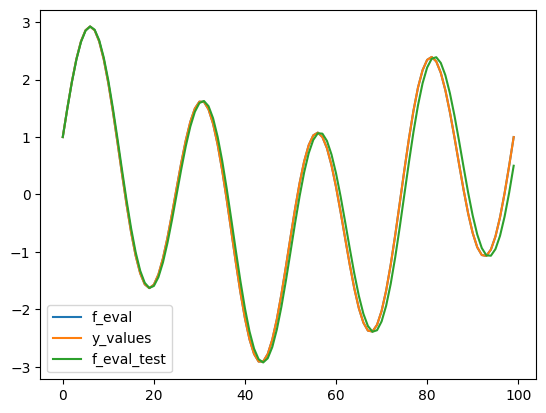

In [21]:
plt.plot(f_eval, label='f_eval')
plt.plot(y_values, label='y_values')
plt.plot(f_eval_test, label='f_eval_test')
plt.legend()

# Elliptic equation in 1D
We will solve the elliptic PDE with Dirichlet bc
\begin{aligned}
-\nu\Delta u + u &= \xi \\
u &= 0
\end{aligned}


If 
$$
u =  \sqrt{\frac{2}{L}}\sum_{i}^\infty c_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

Then 
$$
\xi =  \sqrt{\frac{2}{L}} \sum_{i}^\infty  \Big(\nu\frac{n^2\pi^2}{L^2} + 1\Big)c_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

Conversely, if 
$$
\xi =  \sqrt{\frac{2}{L}} \sum_{i}^\infty \xi_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

then 

$$
u =  \sqrt{\frac{2}{L}}\sum_{i}^\infty \frac{\xi_i}{(\nu\frac{n^2\pi^2}{L^2} + 1\Big)} \sin\Big(\frac{n\pi x}{L}\Big)
$$



In [72]:
key = random.PRNGKey(0)

n_coef = 5000
coef_f = random.normal(key, shape= (n_coef,))
# We pad the coefficients with a zero
c = 0.0 # constant
coef_f_pad = jnp.hstack([jnp.zeros(1)+ 2*c, coef_f])
coef_f_cos =  jnp.hstack([jnp.zeros(1)+ 2*c,jnp.zeros(n_coef)])

In [76]:
lower = 0.0
upper = 1.0

In [73]:
f_values =  evaluate_real_domain(coef_f_cos,coef_f_pad)

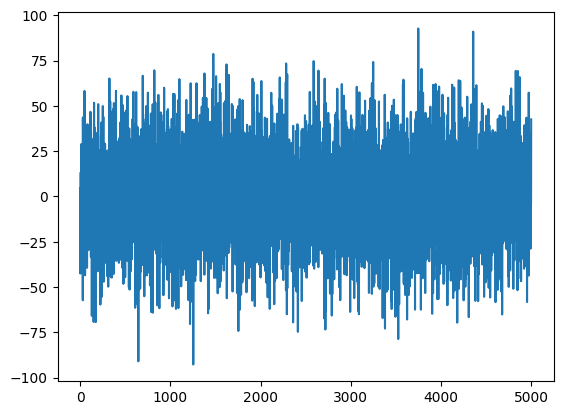

In [74]:
plt.plot(f_values)

In [86]:
# Spectral method 
nu = 0.01
coef_u = coef_f_pad/(nu*jnp.pi*jnp.arange(n_coef+1)**2 + 1)

In [93]:
u_values = evaluate_real_domain(coef_f_cos,coef_u)*jnp.sqrt(2)

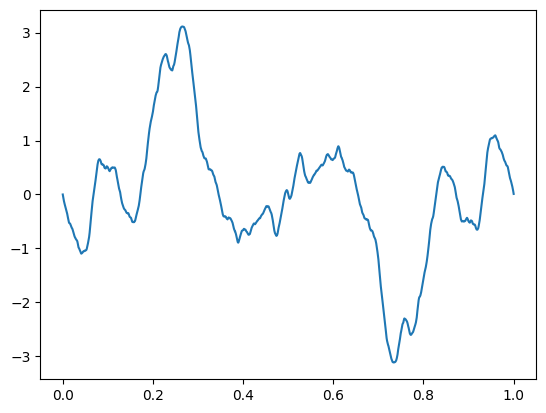

In [94]:
plt.plot(jnp.linspace(0,1,n_coef+1), u_values)
plt.show()

## Kernel method with FFT

We need to calculate

$$
\int \int \varphi_i(x)\varphi_j(y)L_y L_x K(x,y) dx dy
$$
where the $\varphi$ are the Fourier basis functions. 

We will do so by using the FFT
$$
\int \int \varphi_i(x)\varphi_j(y)L_y L_x K(x,y) dx dy \approx \mathcal{F}_y \mathcal{F}_x L_y L_x K(x,y)
$$

In [95]:
from utils_elliptic_coef import L_b_xy

# A 2D example

In [525]:
j,k= 1,5
m,n = 2,4
f = lambda x,y: jnp.cos(2*jnp.pi*(j*x + k*y)) + 4.12*jnp.sin(2*jnp.pi*(m*x + n*y))

In [526]:
domain = jnp.array([0,1])

# 2d grid 
x = jnp.linspace(domain[0], domain[1], n_points)
y = jnp.linspace(domain[0], domain[1], n_points)
X, Y = jnp.meshgrid(x, y)

In [527]:
values = f(X,Y)

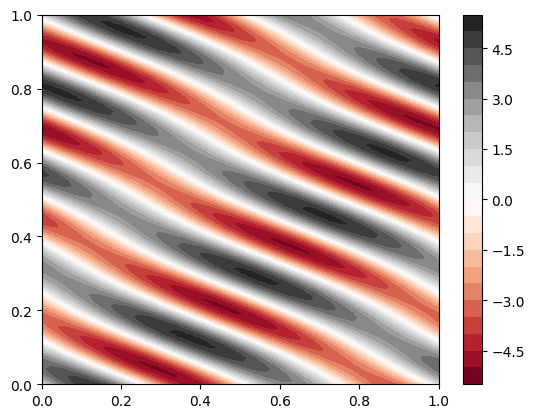

In [528]:
# 2D plot
plt.contourf(X, Y, values, 20, cmap='RdGy')
plt.colorbar()

In [529]:
alpha = fft.fft2(values)

In [530]:
def get_cos_sin_coef_2d(alpha):
    n = alpha.shape[0]
    m = alpha.shape[1]
    c = alpha[0,0].real/(n*m)
    a = 2*alpha.real/(n*m)
    b = -2*alpha.imag/(n*m)
    return a, b, c


In [531]:
a, b, c = get_cos_sin_coef_2d(alpha)

In [532]:
def evaluate_real_domain(a,b):
    m,n = a.shape
    return fft.ifftn((a - 1j*b)*(m*n)/2).real

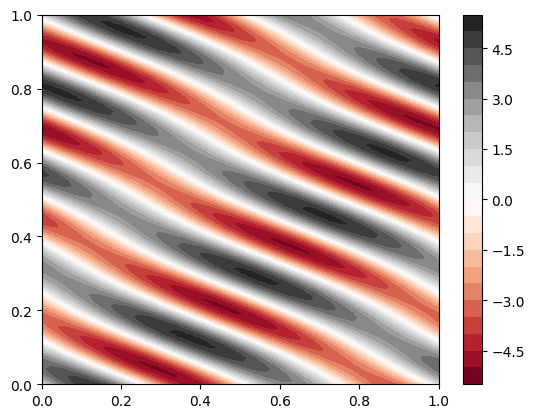

In [533]:
f_eval = evaluate_real_domain(a,b)
# 2D plot
plt.contourf(X, Y, f_eval, 20, cmap='RdGy')
# colorbar
plt.colorbar()

In [534]:
jnp.mean(jnp.abs(f_eval - values))

Array(6.91410817e-16, dtype=float64)

In [535]:
a[k,j], b[n,m]

(Array(0.97736724, dtype=float64), Array(4.0334417, dtype=float64))

In [559]:
a_test = jnp.zeros((n_points,n_points), dtype=jnp.float64)
b_test = jnp.zeros((n_points,n_points), dtype=jnp.float64)  

a_test = a_test.at[k,j].set(1)
b_test = b_test.at[n,m].set(2)*4.12

In [564]:
a[k,j], b[n,m]

(Array(0.97736724, dtype=float64), Array(4.0334417, dtype=float64))

In [560]:
f_eval_test = evaluate_real_domain(a_test,b_test)
jnp.mean(jnp.abs(f_eval_test - values))

Array(0.56350486, dtype=float64)

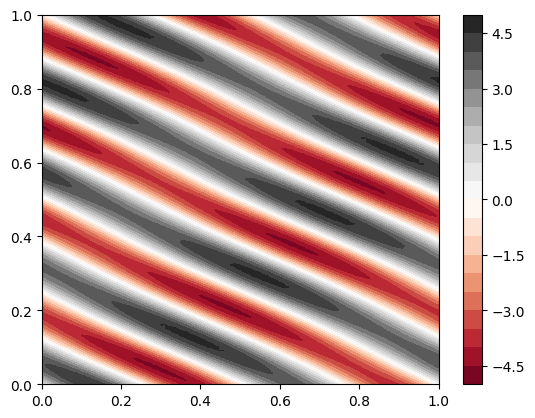

In [561]:
plt.contourf(X, Y, f_eval_test, 20, cmap='RdGy')
# colorbar
plt.colorbar()

# Elliptic equation in 1D
We will solve the elliptic PDE with Dirichlet bc
\begin{aligned}
-\nu\Delta u + u &= \xi \\
u &= 0
\end{aligned}


If 
$$
u =  \sqrt{\frac{2}{L}}\sum_{i}^\infty c_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

Then 
$$
\xi =  \sqrt{\frac{2}{L}} \sum_{i}^\infty  \Big(\nu\frac{n^2\pi^2}{L^2} + 1\Big)c_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

Conversely, if 
$$
\xi =  \sqrt{\frac{2}{L}} \sum_{i}^\infty \xi_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

then 

$$
u =  \sqrt{\frac{2}{L}}\sum_{i}^\infty \frac{\xi_i}{(\nu\frac{n^2\pi^2}{L^2} + 1\Big)} \sin\Big(\frac{n\pi x}{L}\Big)
$$

